# Autoencoder

## 1. Autoencoder with linear layer

Import library

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
import numpy as np
import matplotlib.pyplot as plt

Get the MNIST dataset

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=[ToTensor(), Normalize()]
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=[ToTensor(), Normalize()]
)

In [4]:
BATCH_SIZE = 64

# Create dataloader
train_dl = DataLoader(training_data, batch_size=BATCH_SIZE)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE)

for X, y in test_dl:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(y)
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Create model

In [104]:
class MyFirstEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.act_fn = nn.ReLU()
        self.linear_layer = nn.Sequential(
            nn.Linear(28*28, 512),
            self.act_fn,
            nn.Linear(512, 256),
            self.act_fn,
            nn.Linear(256, 100),
            self.act_fn,
            nn.Linear(100, 30)
        )
    def forward(self, x):
        #print(x.shape)
        x = self.flatten(x)
        x = self.linear_layer(x)
        #print(x.shape)
        return x

class MyFirstDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_fn = nn.ReLU()
        self.linear_layer = nn.Sequential(
            nn.Linear(30, 100),
            self.act_fn,
            nn.Linear(100, 256),
            self.act_fn,
            nn.Linear(256, 512),
            self.act_fn,
            nn.Linear(512, 28*28)
        )
    def forward(self, x):
        x = self.linear_layer(x)
        #print(x.shape)
        x = torch.reshape(x, (-1, 1, 28, 28))
        #print(x.shape)
        return x

class MyFirstAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = MyFirstEncoder()
        self.decoder = MyFirstDecoder()
        
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

In [105]:
model1 = MyFirstAutoencoder().to(device)

In [106]:
from torchsummary import summary
summary(model1, input_size=(1,28,28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 256]         131,328
              ReLU-6                  [-1, 256]               0
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 100]          25,700
              ReLU-9                  [-1, 100]               0
             ReLU-10                  [-1, 100]               0
           Linear-11                   [-1, 30]           3,030
   MyFirstEncoder-12                   [-1, 30]               0
           Linear-13                  [-1, 100]           3,100
             ReLU-14                  [

In [95]:
class CNNEncoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=16, latent_dim=20, act_fn=nn.ReLU()):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), # (28, 28)
            act_fn,
            nn.Conv2d(out_channels, out_channels, 3, padding=1), 
            act_fn,
            nn.Conv2d(out_channels, 2*out_channels, 3, padding=1, stride=2), # (14, 14)
            act_fn,
            nn.Conv2d(2*out_channels, 2*out_channels, 3, padding=1),
            act_fn,
            nn.Conv2d(2*out_channels, 4*out_channels, 3, padding=1, stride=2), # (7, 7)
            act_fn,
            nn.Conv2d(4*out_channels, 4*out_channels, 3, padding=1),
            act_fn,
            nn.Flatten(),
            nn.Linear(4*out_channels*7*7, latent_dim),
            act_fn
        )
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.net(x)
        return x
class CNNDecoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=16, latent_dim=20, act_fn=nn.ReLU()):
        super().__init__()
    
        self.out_channels = out_channels
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4*out_channels*7*7),
            act_fn
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(4*out_channels, 4*out_channels, 3, padding=1), # (7, 7)
            act_fn,
            nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, padding=1, 
                               stride=2, output_padding=1), # (14, 14)
            act_fn,
            nn.ConvTranspose2d(2*out_channels, 2*out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(2*out_channels, out_channels, 3, padding=1, 
                               stride=2, output_padding=1), # (28, 28)
            act_fn,
            nn.ConvTranspose2d(out_channels, out_channels, 3, padding=1),
            act_fn,
            nn.ConvTranspose2d(out_channels, in_channels, 3, padding=1)
        )
    
    def forward(self, x):
        output = self.linear(x)
        output = output.view(-1, 4*self.out_channels, 7, 7)
        output = self.conv(output)
        return output
    
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = CNNEncoder()
        self.decoder = CNNDecoder()
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [96]:
model2 = CNNAutoencoder().to(device)

In [97]:
summary(model2, input_size=(1,28,28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 16, 28, 28]           2,320
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
              ReLU-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 32, 14, 14]           9,248
              ReLU-8           [-1, 32, 14, 14]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11             [-1, 64, 7, 7]          36,928
             ReLU-12             [-1, 64, 7, 7]               0
          Flatten-13                 [-1, 3136]               0
           Linear-14                   

Define loss and optimizer

In [107]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(),
                            lr=1e-3)

Create train and test step

In [108]:
import torch.utils
import torch.utils.data


def train_step(dataloader: torch.utils.data.DataLoader,
               model: torch.nn.Module,
               loss_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = "cpu"):
    size = len(dataloader.dataset)
    
    model.train()
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        # 1. Forward
        logits = model(X)
        
        # 2. Calculate loss
        loss = loss_fn(logits, X)
        total_loss += loss
        
        # 3. Backpropagation
        loss.backward()
        
        # 4. Optimizer step
        optimizer.step()
        
        # 5. Zero grad
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    total_loss /= len(dataloader)
    return total_loss

def test_step(dataloader: torch.utils.data.DataLoader,
               model: torch.nn.Module,
               loss_fn,
               device: torch.device = "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
    
    test_loss /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct
        
        

In [133]:
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

In [134]:
epochs = 20

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_step(dataloader=train_dl,
                            model=model2,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            device=device)
    test_loss, accuracy = test_step(dataloader=test_dl,
                            model=model2,
                            loss_fn=loss_fn,
                            device=device)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_accuracy_history.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 0.020883  [   64/60000]
loss: 0.022585  [ 6464/60000]
loss: 0.021048  [12864/60000]
loss: 0.025561  [19264/60000]
loss: 0.022239  [25664/60000]
loss: 0.024487  [32064/60000]
loss: 0.022374  [38464/60000]
loss: 0.024346  [44864/60000]
loss: 0.022780  [51264/60000]
loss: 0.022104  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.023409 

Epoch 2
-------------------------------
loss: 0.020883  [   64/60000]
loss: 0.022585  [ 6464/60000]
loss: 0.021048  [12864/60000]
loss: 0.025561  [19264/60000]
loss: 0.022239  [25664/60000]
loss: 0.024487  [32064/60000]
loss: 0.022374  [38464/60000]
loss: 0.024346  [44864/60000]
loss: 0.022780  [51264/60000]
loss: 0.022104  [57664/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.023409 

Epoch 3
-------------------------------
loss: 0.020883  [   64/60000]
loss: 0.022585  [ 6464/60000]
loss: 0.021048  [12864/60000]
loss: 0.025561  [19264/60000]
loss: 0.022239  [25664/60000]
loss: 0.024487  [32064/60000

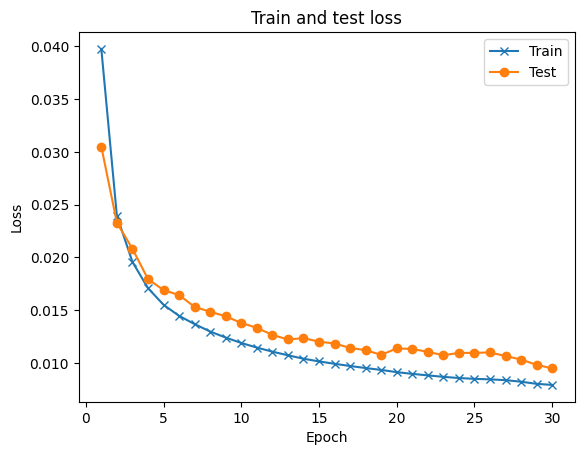

In [126]:
import matplotlib.pyplot as plt
import numpy as np
train_loss_history_tensor = torch.Tensor(train_loss_history).cpu()
test_loss_history_tensor = torch.Tensor(test_loss_history).cpu()
plt.plot(np.arange(1,31), train_loss_history_tensor, marker='x')
plt.plot(np.arange(1,31), test_loss_history_tensor, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test loss")
plt.legend(["Train", "Test"])

In [132]:
torch.save(model2.state_dict(), "autoencoder_cnn.pth")
print("saved Pytorch model state to the autoencoder_cnn.pth")

saved Pytorch model state to the autoencoder_cnn.pth


In [129]:
model1.eval()
idx = 54

x, y = test_data[idx][0], test_data[idx][1]

x = x[np.newaxis, :]

with torch.inference_mode():
    x = x.to(device)
    pred = model1(x)
    

C:\Users\letha\AppData\Local\Temp\ipykernel_22772\3135132700.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(x[0]).cpu()
C:\Users\letha\AppData\Local\Temp\ipykernel_22772\3135132700.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstruct_image = torch.tensor(pred[0]).cpu()


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


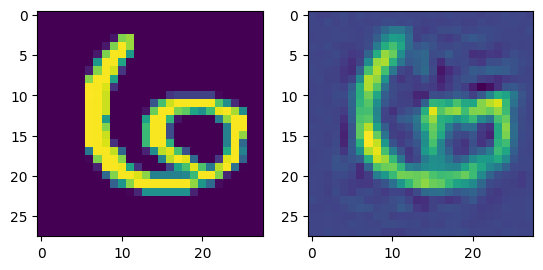

In [130]:
from PIL import Image
plt.subplot(1,2,1)
image = torch.tensor(x[0]).cpu()
reconstruct_image = torch.tensor(pred[0]).cpu()
print(image.shape)
print(reconstruct_image.shape)
plt.imshow(image.reshape(28,28,1))
plt.subplot(1,2,2)
plt.imshow(reconstruct_image.reshape(28,28,1))
plt.savefig(str('autoencoder_linear4.jpg'), bbox_inches='tight')